In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as sma
import itertools
import datetime
import matplotlib
import pytest

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt, exp

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

sns.set_style('whitegrid')

from src.data.dataset_generator import DatasetGenerator
from src.data.data_transformer import DataTransformer

# 1. Reading in the Data from the API

Download the Data (Montel Data & Weather Data; Entsoe Data is still missing)

In [ ]:
dg = DatasetGenerator(['all'])
dataset_latest = dg.get_dataset('2016-01-01', 'latest', 'ignored')

# 2. Data Preprocessing

Set datetime as index of the dataframe and display the length and timerange of the downloaded dataset.

In [3]:
# Extract Length, and Timerange of the Downloaded Dataset
X = dataset_latest.Time

datapoints = X.index.max()
date_min = X.min()
date_max = X.max()

print('Number of datapoints in the Dataset: {}'.format(datapoints))
print('Minimum date from data set: {}'.format(date_min))
print('Maximum date from data set: {}'.format(date_max))

# Change Index from Dataframe (new index: Time)
data_hourly = dataset_latest.set_index('Time')
data_hourly.index = pd.date_range(date_min,date_max,freq='H')

Number of datapoints in the Dataset: 49007
Minimum date from data set: 2016-01-01 00:00:00
Maximum date from data set: 2021-08-03 23:00:00


## 2.1 Display Data Characteristics

In [4]:
data_hourly

,SPOTPrice,temp,dwpt,rhum,prcp,wspd,pres,tsun
2016-01-01 00:00:00,23.86,5.2,4.9,98.0,0.1,1.4,1026.6,0.0
2016-01-01 01:00:00,22.39,4.7,4.6,99.0,0.0,3.2,1026.4,0.0
2016-01-01 02:00:00,20.59,3.8,3.7,99.0,0.5,4.3,1026.9,0.0
2016-01-01 03:00:00,16.81,4.0,3.9,99.0,0.5,4.0,1027.4,0.0
2016-01-01 04:00:00,17.41,4.0,3.9,99.0,0.6,4.0,1027.5,0.0
...,...,...,...,...,...,...,...,...
2021-08-03 19:00:00,119.49,20.3,10.1,52.0,0.0,9.3,1013.5,0.0
2021-08-03 20:00:00,117.68,20.3,10.1,52.0,0.0,9.3,1013.5,0.0
2021-08-03 21:00:00,110.00,20.3,10.1,52.0,0.0,9.3,1013.5,0.0
2021-08-03 22:00:00,104.90,20.3,10.1,52.0,0.0,9.3,1013.5,0.0


In [5]:
data_hourly.describe()

,SPOTPrice,temp,dwpt,rhum,prcp,wspd,pres,tsun
count,49008.000000,49008.000000,49008.000000,49008.000000,49008.000000,49008.000000,49008.000000,49008.000000
mean,37.833762,10.726302,5.147003,71.629489,0.111951,10.115399,1017.348704,13.623194
std,19.490082,8.269747,6.626548,18.353760,0.663149,5.645768,8.633830,22.766709
min,-130.090000,-13.900000,-17.500000,15.000000,0.000000,0.000000,982.000000,0.000000
25%,27.120000,4.200000,-0.100000,58.000000,0.000000,6.100000,1012.300000,0.000000
50%,36.190000,10.400000,4.900000,76.000000,0.000000,8.600000,1017.400000,0.000000
75%,47.510000,16.800000,10.900000,87.000000,0.000000,12.600000,1022.400000,22.000000
max,200.040000,35.800000,20.700000,100.000000,37.500000,49.000000,1047.100000,60.000000


## 2.3 Extract each Feature from the Dataframe

Each Feature of the Dataframe is extracted as Pandas Series

In [4]:
data_spot = data_hourly.SPOTPrice
data_temp = data_hourly.temp
data_dwpt = data_hourly.dwpt
data_rhum = data_hourly.rhum
data_prcp = data_hourly.prcp
data_wspd = data_hourly.wspd
data_pres = data_hourly.pres
data_tsun = data_hourly.tsun

## 2.4 Create Spotprice Datasets with different length (Final Week excluded)

For testing univariant spot price forecasting, subdivide the whole dataset into datasets with the following lengths \
(final week is excluded for the model evaluation; will be changed for a better quality in evaluation):
* previous 5 and 1 year/-s
* previous 6, 3 and 1 month/-s
* previous 3, 2 and 1 week/-s
* previous 5, 4, 3, 2 and 1 day/-s

In [5]:
# Testing set for Walk Forward Evaluation (+1h and +24h)
df_test = data_spot.iloc[-169:]
# Training and Validation Sets for Model Training and Hyperparameter Tuning
df_all = data_spot.iloc[:-169]
df_5a = data_spot.iloc[38568:-169]
df_1a = data_spot.iloc[73632:-169]
df_6m = data_spot.iloc[-4512:-169]
df_3m = data_spot.iloc[-2304:-169]
df_1m = data_spot.iloc[-912:-169]
df_3w = data_spot.iloc[-672:-169]
df_2w = data_spot.iloc[-504:-169]
df_1w = data_spot.iloc[-336:-169]
df_5d = data_spot.iloc[-288:-169]
df_4d = data_spot.iloc[-264:-169]
df_3d = data_spot.iloc[-240:-169]
df_2d = data_spot.iloc[-216:-169]
df_1d = data_spot.iloc[-192:-169]

# 3. Baseline Models

In the section below, the final datetime for the training set can be determined. For testing purposes, this was used as the final training value, in order to test the functionality for the baseline models. 

In [6]:
# Final Date for Training Set (Format: YEAR-MONTH-DAY XX:YY:ZZ)
# Prediction from this Timestamp: +1h; +24h; +168h
split_date = pd.Timestamp('2021-07-13 16:00:00')

### Note:
#### The model performances are measured with a mean metric scoring value after evaluation and compared with each other. For the two Naive Models, this will be added in the following days.

## 3.1. Naive

This is the simplest model for prediction and used as a baseline model. This model uses the latest datavalue for all the following prediction values.

### 3.1.1 Naive Function for Visualisation

In [12]:
def vis_naive_model(data, pred_ind):
    """
    Naive model forecasting for visualization purposes
    Every future prediction value is set to the latest value in the training set
    The final datetime value determines the end of the training set
    :param data: pandas series or dataframe of the spotprice data
    :param pred_ind: latest datetime (format: YYYY-MM-DD HH:MM:SS) in training set
    :return pred_naive: pandas series containing prediciton values
    """
    
    # check if data contains pred_ind (pred_ind = date)
    if (pred_ind not in data.index):
        raise ValueError('Please ensure that the Dataframe contains the Start Prediction Index.')

    # prepare prediciton indexes
    start = len(data.loc[:pred_ind])
    dti = data.index[start:]
    
    # pandas series with every prediction value set to latest training set value
    pred_naive = pd.Series(data=data.loc[pred_ind], index=dti)
    
    # plot input data and prediction values
    plt.figure(figsize=[20,10])
    plt.plot(data, 'b', label='Data')
    plt.plot(pred_naive.index, pred_naive, 'r', label='Prediction')
    plt.legend()
    
    return pred_naive

2021-07-13 17:00:00    91.92
2021-07-13 18:00:00    91.92
2021-07-13 19:00:00    91.92
2021-07-13 20:00:00    91.92
2021-07-13 21:00:00    91.92
                       ...  
2021-07-27 18:00:00    91.92
2021-07-27 19:00:00    91.92
2021-07-27 20:00:00    91.92
2021-07-27 21:00:00    91.92
2021-07-27 22:00:00    91.92
Freq: H, Length: 342, dtype: float64


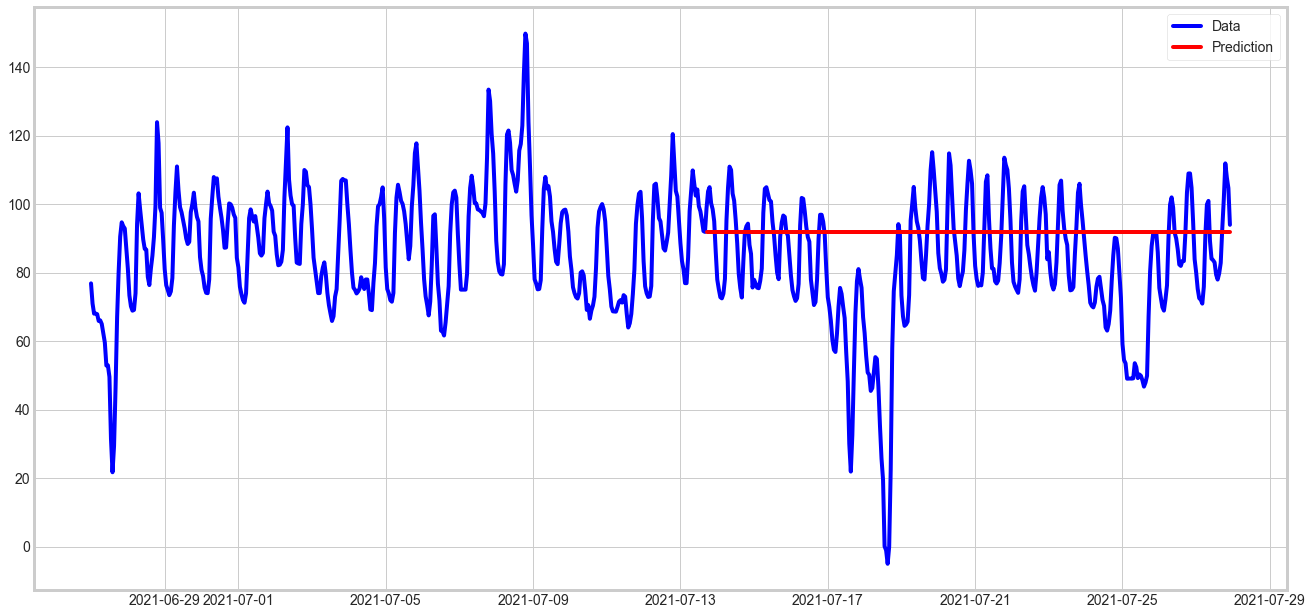

In [14]:
vis_naive = vis_naive_model(df_1m,split_date)
print(vis_naive)

### 3.1.2 Naive Function for Final Usage

In [27]:
def naive_model(data, pred_ind):
    """
    Naive model forecasting for +1h, +24h, +168h
    All three future prediction values are set to the latest value in the training set
    The final datetime value determines the end of the training set
    :param data: pandas series or dataframe of the spotprice data
    :param pred_ind: latest datetime (format: YYYY-MM-DD HH:MM:SS) in training set
    :return pred_naive: pandas series containing all three prediciton values
    """
    
    # check if data contains pred_ind (pred_ind = date)
    if (split_ind not in data.index):
        raise ValueError('Please ensure that the Dataframe contains the Start Prediction Index.')

    # prepare prediction indexes
    n_idx = len(data.loc[:pred_ind])
    dt = data.index
    dti = pd.to_datetime([dt[n_idx],dt[n_idx+23],dt[n_idx+167]])
    
    # pandas series containing all three prediction values with latest value in training set
    pred_naive = pd.Series(data=data.loc[pred_ind], index=dti)
    
    return pred_naive

In [30]:
naive = naive_model(df_1m,split_date)
print(naive)

2021-07-13 17:00:00    91.92
2021-07-14 16:00:00    91.92
2021-07-20 16:00:00    91.92
dtype: float64


## 3.2 SNaive

Another simple baseline model, which predicts the datepoints of interest with the data from the previous year (seasonality). \
As it can be seen in the plot below, the performance of this model is very poor. This model uses the spot price values from the previous year. In order to improve the performance, a bias from the trend difference of both years can be added. This should eliminate the offset between the real data and the prediction. 

### 3.2.1 SNaive Function for Visualisation

In [34]:
def vis_snaive_model(data, pred_ind):
    """
    SNaive model forecasting for visualization purposes
    Every future prediction value is set to the latest value of the previous seasonality in the training set
    The final datetime value determines the end of the train set
    :param data: pandas series or dataframe of the spotprice data
    :param pred_ind: latest datetime (format: YYYY-MM-DD HH:MM:SS) in training set
    :return pred_naive: pandas series containing prediciton values
    """
    
    # indexes for getting the values of the previous seasonality (here: previous year)
    date_1a_start = pred_ind - datetime.timedelta(days=365,hours=-1)
    date_1a_end = data.index[-1] - datetime.timedelta(days=365)
    
    # check if data contains pred_ind (pred_ind = date)
    if (pred_ind not in data.index):
        raise ValueError('Please ensure that the Dataframe contains the Start Prediction Index.')
    
    # checking if data from previous seasonality is available in the dataset
    elif (date_1a_start not in data.index):
        raise ValueError('Please ensure that the Dataframe contains Data from at least one Year ago.')
    
    # prepare prediction indexes
    n_idx = len(data.loc[:pred_ind])
    dti = data.index[n_idx:]
    
    # get the values of the previous seasonality
    data = data[date_1a_start:date_1a_end].values
    
    # pandas series containing all prediction values
    pred_snaive = pd.Series(data=data, index=dti)
    
    return pred_snaive

In [35]:
vis_snaive = vis_snaive_model(df_5a,split_date)

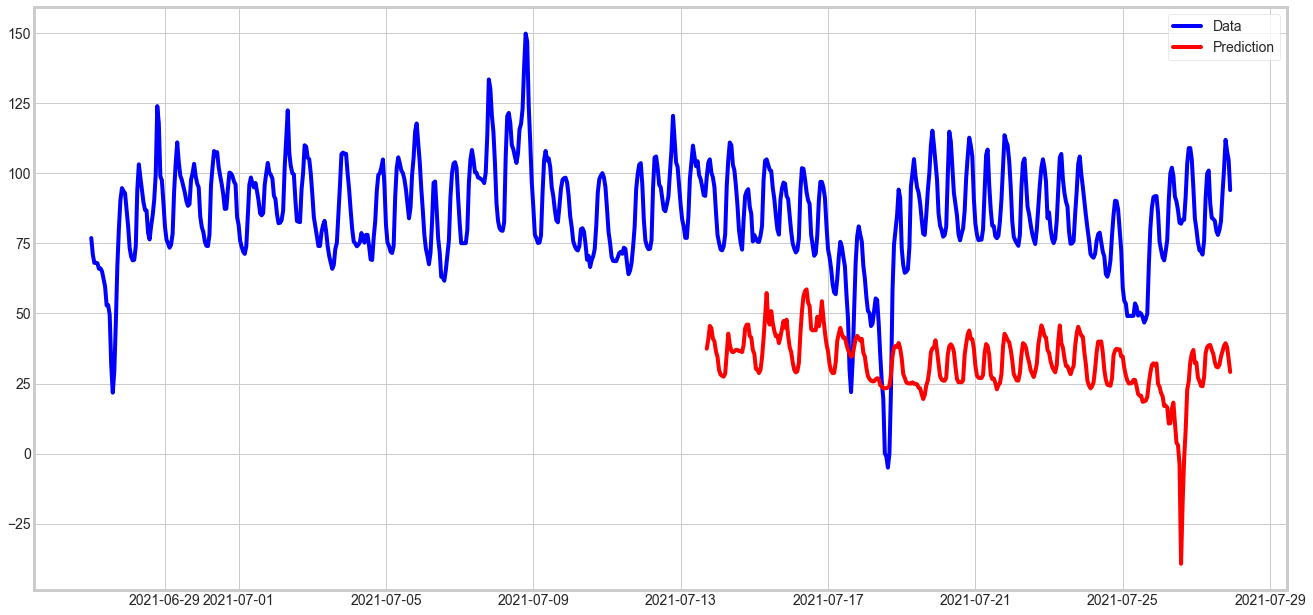

In [36]:
plt.figure(figsize=[20,10])
plt.plot(df_1m, 'b', label='Data')
plt.plot(vis_snaive, 'r', label='Prediction')
plt.legend()

### 3.2.2 SNaive Function for Final Usage

In [41]:
def snaive_model(data, pred_ind):
    """
    SNaive model forecasting for visualization purposes
    Every future prediction value is set to the latest value of the previous seasonality in the training set
    The final datetime value determines the end of the train set
    :param data: pandas series or dataframe of the spotprice data
    :param pred_ind: latest datetime (format: YYYY-MM-DD HH:MM:SS) in training set
    :return pred_naive: pandas series containing prediciton values
    """
    
    # index for getting the values of the previous seasonality (here: previous year)
    date_1a = pred_ind - datetime.timedelta(days=365)
    
    # check if data contains pred_ind (pred_ind = date)
    if (pred_ind not in data.index):
        raise ValueError('Please ensure that the Dataframe contains the Start Prediction Index.')
    # checking if data from previous seasonality is available in the dataset
    elif (date_1a not in data.index):
        raise ValueError('Please ensure that the Dataframe contains Data from at least one Year ago.')
    
    # prepare prediction indexes
    n_idx = len(data.loc[:pred_ind])
    dt = data.index
    dti = pd.to_datetime([dt[n_idx],dt[n_idx+23],dt[n_idx+167]])
    
    # get predicition values from previous seasonality
    data = np.array([data.loc[date_1a+datetime.timedelta(hours=1)],data.loc[date_1a+datetime.timedelta(hours=24)],
                    data.loc[date_1a+datetime.timedelta(hours=168)]])
    
    # pandas series containing all three prediction values
    pred_snaive = pd.Series(data=data, index=dti)
    
    return pred_snaive

In [42]:
snaive = snaive_model(df_5a,split_date)
print(snaive)

2021-07-13 17:00:00    37.41
2021-07-14 16:00:00    36.20
2021-07-20 16:00:00    26.14
dtype: float64


# 4. Valdiation and Evaluation Methods

## 4.1 Rolling Forecast (For Validation)

Rolling Forecast with an example gap of `gap=3`
* blue = train set
* red = validation set

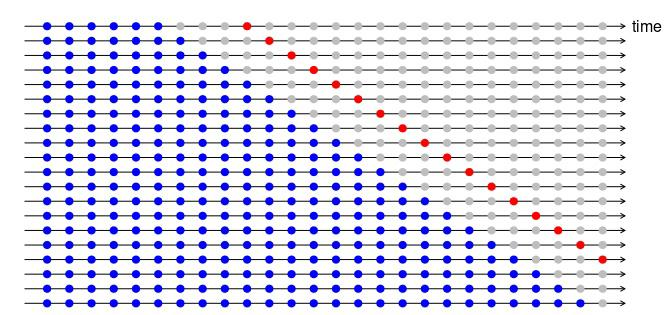

Rolling Foreccast with no gap

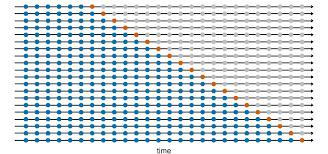

In [38]:
def rolling_forecast(data,min_train,gap):
    """
    Splitting the dataset with a rolling forecast validation method
    The first iteration returns a training dataset with min_train length and one validation set of length one
    After each iteration the training set is increased by the size of one sample
    Between the training set and the validation set is a gap for skipped values
    (+1h: gap=0; +24h: gap=23; +168h: gap = 167)
    :param data: pandas series or dataframe of the training and validation spotprice data
    :param min_train: length of the dataset for the first iteration
    :param gap: skipped values between training and validation set
    :yield split_train:
    :yield split_val:
    """
    
    for i in range(len(data)-min_train-gap):
        split_train = data[:min_train+i]
        split_val = data[min_train+i+gap:min_train+i+gap+1]
        yield split_train, split_val

For the project, there are three gaps of interest. Predicting +1h, +24 and +168h. Therefore we determine our min_train_size for cross validation. For Prediction of +1h, set `gap=0`; for prediction of +24h, set `gap=23`; for prediction of +168h set `gap=167`.

In [11]:
rolling_1h = rolling_forecast(df_1d, 10, gap=0)

In [12]:
i=0
for cv_train,cv_val in rolling_1h:
    print(f'CV[{i+1}]')
    print(f'Train:\t{cv_train}')
    print(f'Val:\t{cv_val}')
    print('------')
    i+=1

CV[1]
Train:	2021-07-27 00:00:00     80.08
2021-07-27 01:00:00     75.30
2021-07-27 02:00:00     72.55
2021-07-27 03:00:00     72.11
2021-07-27 04:00:00     70.98
2021-07-27 05:00:00     75.92
2021-07-27 06:00:00     91.05
2021-07-27 07:00:00     99.92
2021-07-27 08:00:00    100.98
2021-07-27 09:00:00     89.27
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-27 10:00:00    84.08
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[2]
Train:	2021-07-27 00:00:00     80.08
2021-07-27 01:00:00     75.30
2021-07-27 02:00:00     72.55
2021-07-27 03:00:00     72.11
2021-07-27 04:00:00     70.98
2021-07-27 05:00:00     75.92
2021-07-27 06:00:00     91.05
2021-07-27 07:00:00     99.92
2021-07-27 08:00:00    100.98
2021-07-27 09:00:00     89.27
2021-07-27 10:00:00     84.08
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-27 11:00:00    83.67
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[3]
Train:	2021-07-27 00:00:00     80.08
2021-07-27 01:00:00     75.30
2021-07-27 02:00:00     7

In [13]:
rolling_24h = rolling_forecast(df_5d,50,gap=23)

In [14]:
i=0
for cv_train,cv_val in rolling_24h:
    print(f'CV[{i+1}]')
    print(f'Train:\t{cv_train}')
    print(f'Val:\t{cv_val}')
    print('------')
    i+=1

CV[1]
Train:	2021-07-23 00:00:00     86.03
2021-07-23 01:00:00     80.10
2021-07-23 02:00:00     76.49
2021-07-23 03:00:00     75.10
2021-07-23 04:00:00     76.66
2021-07-23 05:00:00     83.02
2021-07-23 06:00:00     94.41
2021-07-23 07:00:00    105.63
2021-07-23 08:00:00    106.91
2021-07-23 09:00:00     98.06
2021-07-23 10:00:00     93.01
2021-07-23 11:00:00     89.95
2021-07-23 12:00:00     88.09
2021-07-23 13:00:00     79.19
2021-07-23 14:00:00     74.85
2021-07-23 15:00:00     75.01
2021-07-23 16:00:00     75.80
2021-07-23 17:00:00     85.45
2021-07-23 18:00:00     93.55
2021-07-23 19:00:00    103.39
2021-07-23 20:00:00    105.97
2021-07-23 21:00:00     99.72
2021-07-23 22:00:00     95.15
2021-07-23 23:00:00     89.92
2021-07-24 00:00:00     85.00
2021-07-24 01:00:00     80.42
2021-07-24 02:00:00     76.30
2021-07-24 03:00:00     71.25
2021-07-24 04:00:00     70.31
2021-07-24 05:00:00     69.87
2021-07-24 06:00:00     71.30
2021-07-24 07:00:00     75.86
2021-07-24 08:00:00     78.

In [15]:
rolling_168h = rolling_forecast(df_2w,150,gap=167)

In [16]:
i=0
for cv_train,cv_val in rolling_168h:
    print(f'CV[{i+1}]')
    print(f'Train:\t{cv_train}')
    print(f'Val:\t{cv_val}')
    print('------')
    i+=1

CV[1]
Train:	2021-07-14 00:00:00    78.00
2021-07-14 01:00:00    75.20
2021-07-14 02:00:00    72.86
2021-07-14 03:00:00    72.51
2021-07-14 04:00:00    73.87
                       ...  
2021-07-20 01:00:00    81.31
2021-07-20 02:00:00    79.70
2021-07-20 03:00:00    77.38
2021-07-20 04:00:00    77.93
2021-07-20 05:00:00    80.90
Freq: H, Name: SPOTPrice, Length: 150, dtype: float64
Val:	2021-07-27 05:00:00    75.92
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[2]
Train:	2021-07-14 00:00:00    78.00
2021-07-14 01:00:00    75.20
2021-07-14 02:00:00    72.86
2021-07-14 03:00:00    72.51
2021-07-14 04:00:00    73.87
                       ...  
2021-07-20 02:00:00    79.70
2021-07-20 03:00:00    77.38
2021-07-20 04:00:00    77.93
2021-07-20 05:00:00    80.90
2021-07-20 06:00:00    99.02
Freq: H, Name: SPOTPrice, Length: 151, dtype: float64
Val:	2021-07-27 06:00:00    91.05
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[3]
Train:	2021-07-14 00:00:00     78.00
2021-07-14 01:00:00  

## 4.2 Sliding Window (For Evaluation)

Sliding Window with not gap:
* black: training set
* pink: test set

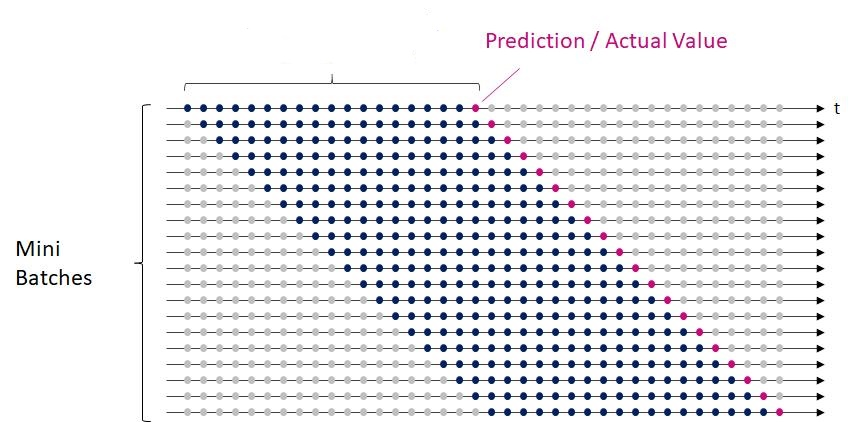

In [43]:
def sliding_window(data,window_size,gap):
    """
    Splitting the dataset with a sliding window evaluation method
    As a queue the training set and validation value are moving on one position after each iteration
    Between the training set and the validation set is a gap for skipped values
    (+1h: gap=0; +24h: gap=23; +168h: gap = 167)
    :param data: pandas series or dataframe for the training and validation spotprice data
    :param window_size: length of the training size
    :param gap: skipped values between training and validation set
    :yield split_train:
    :yield split_val:
    """
    
    for i in range(len(data)-window_size-gap):
        split_train = data[i:window_size+i]
        split_val = data[i+window_size+gap:i+window_size+gap+1]
        yield split_train, split_val

For the project, there are three gaps of interest. Predicting +1h, +24 and +168h. Therefore we determine our min_train_size for cross validation. For Prediction of +1h, set `gap=0`; for prediction of +24h, set `gap=23`; for prediction of +168h set `gap=167`.

In [50]:
sliding_1h = sliding_window(df_1d, 10, gap=0)
i=0
for cv_train,cv_val in sliding_1h:
    print(f'CV[{i+1}]')
    print(f'Train:\t{cv_train}')
    print(f'Val:\t{cv_val}')
    print('------')
    i+=1

CV[1]
Train:	2021-07-27 00:00:00     80.08
2021-07-27 01:00:00     75.30
2021-07-27 02:00:00     72.55
2021-07-27 03:00:00     72.11
2021-07-27 04:00:00     70.98
2021-07-27 05:00:00     75.92
2021-07-27 06:00:00     91.05
2021-07-27 07:00:00     99.92
2021-07-27 08:00:00    100.98
2021-07-27 09:00:00     89.27
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-27 10:00:00    84.08
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[2]
Train:	2021-07-27 01:00:00     75.30
2021-07-27 02:00:00     72.55
2021-07-27 03:00:00     72.11
2021-07-27 04:00:00     70.98
2021-07-27 05:00:00     75.92
2021-07-27 06:00:00     91.05
2021-07-27 07:00:00     99.92
2021-07-27 08:00:00    100.98
2021-07-27 09:00:00     89.27
2021-07-27 10:00:00     84.08
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-27 11:00:00    83.67
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[3]
Train:	2021-07-27 02:00:00     72.55
2021-07-27 03:00:00     72.11
2021-07-27 04:00:00     70.98
2021-07-27 05:00:00     7

In [52]:
sliding_24h = sliding_window(df_1w, 10, gap=23)
i=0
for cv_train,cv_val in sliding_24h:
    print(f'CV[{i+1}]')
    print(f'Train:\t{cv_train}')
    print(f'Val:\t{cv_val}')
    print('------')
    i+=1

CV[1]
Train:	2021-07-21 00:00:00     82.01
2021-07-21 01:00:00     78.18
2021-07-21 02:00:00     76.15
2021-07-21 03:00:00     76.50
2021-07-21 04:00:00     76.30
2021-07-21 05:00:00     80.00
2021-07-21 06:00:00     93.26
2021-07-21 07:00:00    106.56
2021-07-21 08:00:00    108.45
2021-07-21 09:00:00     95.91
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-22 09:00:00    96.92
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[2]
Train:	2021-07-21 01:00:00     78.18
2021-07-21 02:00:00     76.15
2021-07-21 03:00:00     76.50
2021-07-21 04:00:00     76.30
2021-07-21 05:00:00     80.00
2021-07-21 06:00:00     93.26
2021-07-21 07:00:00    106.56
2021-07-21 08:00:00    108.45
2021-07-21 09:00:00     95.91
2021-07-21 10:00:00     87.07
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-22 10:00:00    88.08
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[3]
Train:	2021-07-21 02:00:00     76.15
2021-07-21 03:00:00     76.50
2021-07-21 04:00:00     76.30
2021-07-21 05:00:00     8

In [54]:
sliding_168h = sliding_window(df_1m, 10, gap=167)
i=0
for cv_train,cv_val in sliding_168h:
    print(f'CV[{i+1}]')
    print(f'Train:\t{cv_train}')
    print(f'Val:\t{cv_val}')
    print('------')
    i+=1

CV[1]
Train:	2021-06-27 00:00:00    76.89
2021-06-27 01:00:00    71.00
2021-06-27 02:00:00    68.05
2021-06-27 03:00:00    68.09
2021-06-27 04:00:00    67.90
2021-06-27 05:00:00    65.92
2021-06-27 06:00:00    66.07
2021-06-27 07:00:00    65.03
2021-06-27 08:00:00    62.29
2021-06-27 09:00:00    59.61
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-04 09:00:00    77.08
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[2]
Train:	2021-06-27 01:00:00    71.00
2021-06-27 02:00:00    68.05
2021-06-27 03:00:00    68.09
2021-06-27 04:00:00    67.90
2021-06-27 05:00:00    65.92
2021-06-27 06:00:00    66.07
2021-06-27 07:00:00    65.03
2021-06-27 08:00:00    62.29
2021-06-27 09:00:00    59.61
2021-06-27 10:00:00    52.89
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-04 10:00:00    75.24
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[3]
Train:	2021-06-27 02:00:00    68.05
2021-06-27 03:00:00    68.09
2021-06-27 04:00:00    67.90
2021-06-27 05:00:00    65.92
2021-06-27 06:00:00

Val:	2021-07-10 19:00:00    97.91
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[156]
Train:	2021-07-03 11:00:00     70.51
2021-07-03 12:00:00     68.12
2021-07-03 13:00:00     65.91
2021-07-03 14:00:00     67.28
2021-07-03 15:00:00     73.00
2021-07-03 16:00:00     75.20
2021-07-03 17:00:00     85.45
2021-07-03 18:00:00     95.42
2021-07-03 19:00:00    106.86
2021-07-03 20:00:00    107.38
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-10 20:00:00    99.19
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[157]
Train:	2021-07-03 12:00:00     68.12
2021-07-03 13:00:00     65.91
2021-07-03 14:00:00     67.28
2021-07-03 15:00:00     73.00
2021-07-03 16:00:00     75.20
2021-07-03 17:00:00     85.45
2021-07-03 18:00:00     95.42
2021-07-03 19:00:00    106.86
2021-07-03 20:00:00    107.38
2021-07-03 21:00:00    106.96
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-10 21:00:00    100.05
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[158]
Train:	2021-07-03 13:00:00     65

Train:	2021-07-08 18:00:00    137.99
2021-07-08 19:00:00    149.83
2021-07-08 20:00:00    147.00
2021-07-08 21:00:00    124.07
2021-07-08 22:00:00    110.94
2021-07-08 23:00:00     96.70
2021-07-09 00:00:00     87.97
2021-07-09 01:00:00     78.07
2021-07-09 02:00:00     76.84
2021-07-09 03:00:00     75.15
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-16 03:00:00    71.77
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[284]
Train:	2021-07-08 19:00:00    149.83
2021-07-08 20:00:00    147.00
2021-07-08 21:00:00    124.07
2021-07-08 22:00:00    110.94
2021-07-08 23:00:00     96.70
2021-07-09 00:00:00     87.97
2021-07-09 01:00:00     78.07
2021-07-09 02:00:00     76.84
2021-07-09 03:00:00     75.15
2021-07-09 04:00:00     75.24
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-16 04:00:00    72.54
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[285]
Train:	2021-07-08 20:00:00    147.00
2021-07-08 21:00:00    124.07
2021-07-08 22:00:00    110.94
2021-07-08 23:00:00     96.

Freq: H, Name: SPOTPrice, dtype: float64
------
CV[424]
Train:	2021-07-14 15:00:00    75.49
2021-07-14 16:00:00    72.76
2021-07-14 17:00:00    83.37
2021-07-14 18:00:00    91.94
2021-07-14 19:00:00    93.58
2021-07-14 20:00:00    94.33
2021-07-14 21:00:00    88.11
2021-07-14 22:00:00    85.50
2021-07-14 23:00:00    75.68
2021-07-15 00:00:00    77.95
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-22    83.01
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[425]
Train:	2021-07-14 16:00:00    72.76
2021-07-14 17:00:00    83.37
2021-07-14 18:00:00    91.94
2021-07-14 19:00:00    93.58
2021-07-14 20:00:00    94.33
2021-07-14 21:00:00    88.11
2021-07-14 22:00:00    85.50
2021-07-14 23:00:00    75.68
2021-07-15 00:00:00    77.95
2021-07-15 01:00:00    76.78
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-22 01:00:00    77.36
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[426]
Train:	2021-07-14 17:00:00    83.37
2021-07-14 18:00:00    91.94
2021-07-14 19:00:00    93.58
202

Train:	2021-07-20 10:00:00     93.01
2021-07-20 11:00:00     88.92
2021-07-20 12:00:00     85.00
2021-07-20 13:00:00     78.30
2021-07-20 14:00:00     76.09
2021-07-20 15:00:00     78.45
2021-07-20 16:00:00     80.30
2021-07-20 17:00:00     86.52
2021-07-20 18:00:00     98.34
2021-07-20 19:00:00    106.00
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-27 19:00:00    111.93
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[564]
Train:	2021-07-20 11:00:00     88.92
2021-07-20 12:00:00     85.00
2021-07-20 13:00:00     78.30
2021-07-20 14:00:00     76.09
2021-07-20 15:00:00     78.45
2021-07-20 16:00:00     80.30
2021-07-20 17:00:00     86.52
2021-07-20 18:00:00     98.34
2021-07-20 19:00:00    106.00
2021-07-20 20:00:00    112.70
Freq: H, Name: SPOTPrice, dtype: float64
Val:	2021-07-27 20:00:00    107.77
Freq: H, Name: SPOTPrice, dtype: float64
------
CV[565]
Train:	2021-07-20 12:00:00     85.00
2021-07-20 13:00:00     78.30
2021-07-20 14:00:00     76.09
2021-07-20 15:00:00     7

# 5. SARIMAX Model

## 5.1 Cross Validation Score

In [39]:
def sarimax_cross_validation_score(cv,metric,par,seas_par):
    """
    Cross validation score for the SARIMAX model
    :param cv: cross validation method (here: rolling_forecast)
    :param metric: metric used for hyperparameter tuning and validation (RMSE; MAE; MAPE; sMAPE)
    :param par: tuple of parameter for the SARIMAX model in format (p,d,q)
    :param seas_par: tuple of seasonal parameter for the SARIMAX model in format (P,D,Q,S)
    :return cv_scores: returns a numpy array of the cross validation score for each iteration
    :return train_len: returns a numpy array of the train dataset length for each iteratiomn
    """
    
    cv_scores=[]
    train_len = []
    for cv_train,cv_val in cv:
        model = SARIMAX(cv_train,order=par,seasonal_order=seas_par)
        model_fit = model.fit(method='powell',disp=False)
        # replace horizon with gap
        preds = model_fit.predict(len(cv_train),len(cv_train))
        score = metric(y_true=cv_val, y_pred=preds)
        cv_scores.append(score)
        train_len.append(len(cv_train)-1)
    return np.array(cv_scores), np.array(train_len)

## 5.2 Hyperparameter Tuning 
#### Perform a GridSearch Finding the Params; Evaluate best Result Value to determine TimeWindow & Parameters

In [40]:
import warnings
warnings.filterwarnings('ignore')

### Function for Tuning still missing: Define Hyperparameter and Function Inputs

Hyperparameters for the SARIMAX Model:
* SARIMAX Model Parameter: (p,d,q)
* SARIMAX Model Sesonal Parameter: (P,D,Q,S)
* Length of the Training Data

#### Mean Squared Error

In [43]:
p = range(0,3)
q = range(0,3)
d = range(0,3)
s = range(24,25)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))

columns = ['Parameter','SeasonalParameter','TrainLength','Score']
df = pd.DataFrame(columns=columns)

for param in pdq:
    for s_param in seasonal_pdq:
        if param[0] == s_param[0] and param[1] == s_param[1] and param[2] == s_param[2]:
            ## IMPORTANT: Determine the used dataset and the start index minimum trainsize and the gap
            cv_rolling_1h = rolling_forecast(df_1w,90,gap=0)
            sc, idx = sarimax_cross_validation_score(cv_rolling_1h,metric=mean_squared_error,par=param,seas_par=s_param)
            min_score = np.min(sc)
            idx_min = np.argmin(sc)
            len_train = idx[idx_min]+1
            df.loc[len(df)] = [param,s_param,len_train,min_score]
        
print(df)

    Parameter SeasonalParameter TrainLength        Score
0   (0, 0, 0)     (0, 0, 0, 24)         110  2184.627600
1   (0, 0, 1)     (0, 0, 1, 24)         153    11.323075
2   (0, 0, 2)     (0, 0, 2, 24)          97     0.002043
3   (0, 1, 0)     (0, 1, 0, 24)         146     0.004900
4   (0, 1, 1)     (0, 1, 1, 24)         120     0.000564
5   (0, 1, 2)     (0, 1, 2, 24)         131     0.001749
6   (0, 2, 0)     (0, 2, 0, 24)          97     0.002500
7   (0, 2, 1)     (0, 2, 1, 24)         152     0.004261
8   (0, 2, 2)     (0, 2, 2, 24)         121     0.000131
9   (1, 0, 0)     (1, 0, 0, 24)         139     0.007907
10  (1, 0, 1)     (1, 0, 1, 24)         106     0.000736
11  (1, 0, 2)     (1, 0, 2, 24)         146     0.004368
12  (1, 1, 0)     (1, 1, 0, 24)         105     0.019315
13  (1, 1, 1)     (1, 1, 1, 24)         146     0.001495
14  (1, 1, 2)     (1, 1, 2, 24)         111     0.024220
15  (1, 2, 0)     (1, 2, 0, 24)         147     0.011260
16  (1, 2, 1)     (1, 2, 1, 24)

#### Mean Absolute Error

In [42]:
p = range(0,3)
q = range(0,3)
d = range(0,3)
s = range(24,25)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))

columns = ['Parameter','SeasonalParameter','TrainLength','Score']
df = pd.DataFrame(columns=columns)

for param in pdq:
    for s_param in seasonal_pdq:
        if param[0] == s_param[0] and param[1] == s_param[1] and param[2] == s_param[2]:
            ## IMPORTANT: Determine the used dataset and the start index minimum trainsize and the gap
            cv_rolling_1h = rolling_forecast(df_1w,90,gap=0)
            sc, idx = sarimax_cross_validation_score(cv_rolling_1h,metric=mean_absolute_error,par=param,seas_par=s_param)
            min_score = np.min(sc)
            idx_min = np.argmin(sc)
            len_train = idx[idx_min]+1
            df.loc[len(df)] = [param,s_param,len_train,min_score]
        
print(df)

    Parameter SeasonalParameter TrainLength      Score
0   (0, 0, 0)     (0, 0, 0, 24)         110  46.740000
1   (0, 0, 1)     (0, 0, 1, 24)         153   3.364978
2   (0, 0, 2)     (0, 0, 2, 24)          97   0.045195
3   (0, 1, 0)     (0, 1, 0, 24)         146   0.070000
4   (0, 1, 1)     (0, 1, 1, 24)         120   0.023757
5   (0, 1, 2)     (0, 1, 2, 24)         131   0.041824
6   (0, 2, 0)     (0, 2, 0, 24)          97   0.050000
7   (0, 2, 1)     (0, 2, 1, 24)         152   0.065273
8   (0, 2, 2)     (0, 2, 2, 24)         121   0.011453
9   (1, 0, 0)     (1, 0, 0, 24)         139   0.088924
10  (1, 0, 1)     (1, 0, 1, 24)         106   0.027132
11  (1, 0, 2)     (1, 0, 2, 24)         146   0.066088
12  (1, 1, 0)     (1, 1, 0, 24)         105   0.138979
13  (1, 1, 1)     (1, 1, 1, 24)         146   0.038666
14  (1, 1, 2)     (1, 1, 2, 24)         111   0.155627
15  (1, 2, 0)     (1, 2, 0, 24)         147   0.106112
16  (1, 2, 1)     (1, 2, 1, 24)         157   0.005891
17  (1, 2,

Missing in Code above: Extract the best model from the GridSearch and the best Time Window & Perform this model on the test set. \
Include Metric Function for MAPE and sMAPE \
Include Visualization for Results of different Metrics, Timelengths and Score

## 5.3 Walk Forward Evaluation (Überarbeiten mit Sliding Window)

function above should return dataframe and tuned hypterparameters with the corresponding length for the sliding window. 

In [ ]:
params = tuple(1,2,1)
s_params = tuple(1,2,1,24)

opt_len = 127
opt_data = data_spot[-169-opt_len:]

In [ ]:
def walk_forward_evaluation(data, params, s_params, window, gap, metric):
    """
    Walk Forward Evaluation after cross validation
    :param data: pandas series or dataframe of the spotprice data
    :param params: tuple of parameter for the SARIMAX model in format (p,d,q)
    :param s_params: tuple of seasonal parameter for the SARIMAX model in format (P,D,Q,S)
    :param window: window for sliding window evaluation
    :param gap: skipped values between training and validation set
    :param metric: metric used for hyperparameter tuning and validation (RMSE; MAE; MAPE; sMAPE)
    :return preds: returns a numpy array with the prediction values for the spot price
    :return score_list: returns a list with float values for the score during evaluation
    """
    
    # check if data contains more samples than the minimum training length
    if len(data) <= opt_len:
        return ValueError('Please ensure that the Dataset contains of more samples.')
    
    sl_window = sliding_window(df_1d, window, gap=gap)
    preds = np.array([])
    score_list = []
    
    for cv_train,cv_eval in sl_window:
        print(f'Train:\t{cv_train}')
        print(f'Val:\t{cv_val}')
        print('-----------------')
        
        # Model and Fitting
        model = SARIMAX(cv_train, order=params, seasonal_order=s_params)
        model_fit = model.fit(disp=False)
        
        # Forecast daily loads for week i
        forecast = model_fit.predict(len(cv_train),len(cv_train))
        print('Predicted Value: {}'.format(forecast))
        preds = np.concatenate((preds, forecast),axis=None)
        
        # Define MAPE & sMAPE as metric
        score = metric(y_true=cv_val, y_pred=preds)
        # Calculate MAPE and add to mape_list
        # mape_score = abs((test-predictions[-1])/test)*100
        print('{} Score: {}'.format(metric, score))
        score_list.append(score)
        print('--------------')
    
    return preds, score_list

In [ ]:
pred_eval, mape_eval = optimal_walk_forward_validation(eval_data)

### Visualize Walk Forward Evaluation

In [162]:
def plot_walk_forward_evaluation(data,pred,window):
    """
    Plotting
    :param data: pandas series or dataframe of the spotprice data
    :param pred: numpy array with the prediction values from the evaluation
    :param window: window for sliding window evaluation
    """
    
    plt.figure(figsize=[20,10])
    plt.plot(data[window:], 'b', label='Data')
    plt.plot(data.index[window:], pred, 'r', label='Prediction')
    plt.legend()

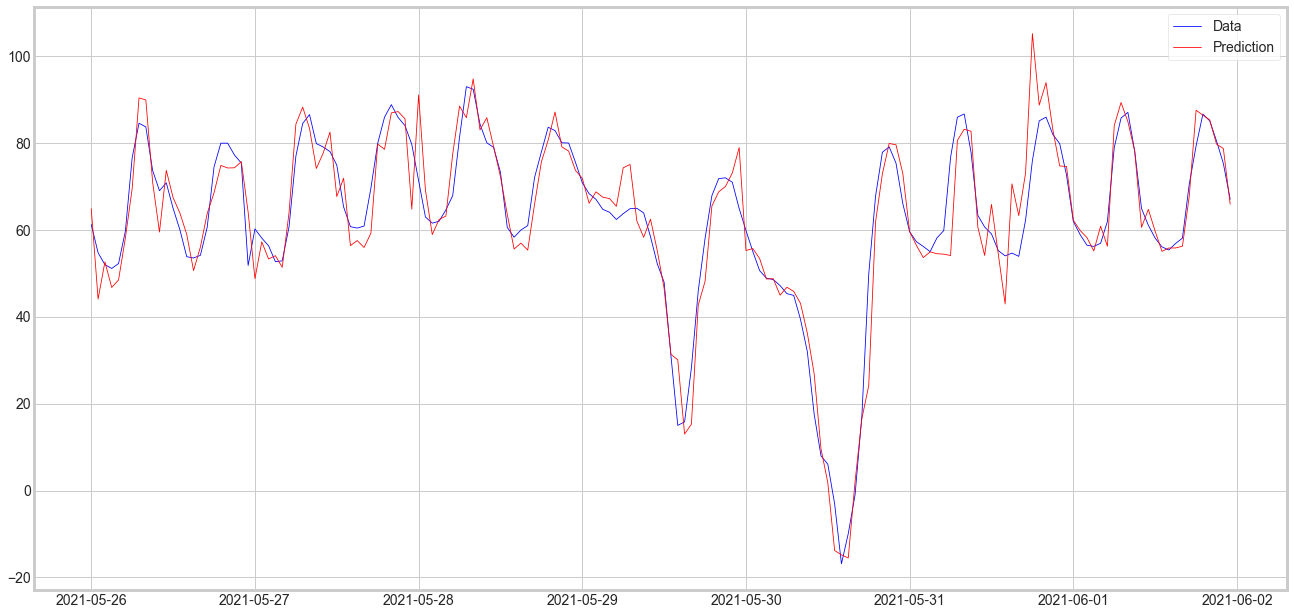

In [163]:
plot_optimal_walk_forward_validation(eval_data, pred_eval,opt_len)

In [ ]:
def plot_walk_forward_evaluation_score(data,pred,window,score):
    """
    Plotting
    :param data: pandas series or dataframe of the spotprice data
    :param pred: numpy array with the prediction values from the evaluation
    :param window: window for sliding window evaluation
    :param score: list of evaluation score
    """
    
    plt.figure(figsize=[20,10])
    plt.plot(data[window:], 'b', label='Data')
    plt.plot(data.index[window:], pred, 'r', label='Prediction')
    plt.plot(eval_data.index[window:], score, 'c', label='Score')
    plt.legend()

(-50.0, 150.0)

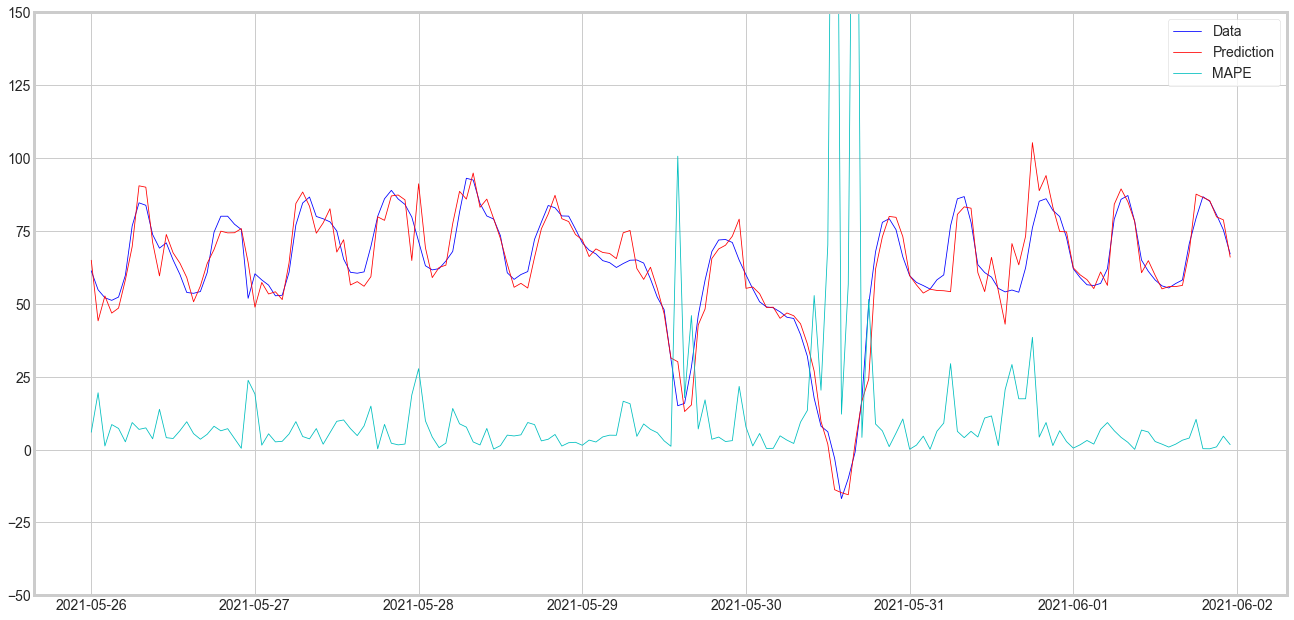

In [167]:
plt.figure(figsize=[20,10])
plt.plot(eval_data[127:], 'b', label='Data')
plt.plot(eval_data.index[127:], pred_eval, 'r', label='Prediction')
plt.plot(eval_data.index[127:], mape_eval, 'c', label='MAPE')
plt.legend()
plt.ylim(-50, 150)

In [165]:
mape_mean = sum(mape_eval)/len(mape_eval)
print(mape_mean)

12.65969391965746


To do's:
* Add missing functionalities and set up a fully automated pipline
* Functions into .py files
* Perform Analogous Hyperparameter Tuning and Walk Forward Evaluation for +24h and +168h
* Compare Performance to ARIMA Model with Seasonal Decomposition
* Include Exogenous Datasets (All features; Most important features etc.) and comparison with other Models
* Include further simple Models such as Vector-ARIMA, Linear Regression etc.